# GNSS Missing Segment Imputation

Notebook này minh họa cách sử dụng VisionTS++ (phiên bản nội bộ) để khôi phục các đoạn số liệu bị thiếu trong ba kênh GNSS `can517501x`, `can517501y`, `can517501z`. Các bước chính:

1. Đọc dữ liệu từ `datasets/GNSS.csv` và chuẩn hóa các giá trị thiếu (`-9999`).
2. Xác định (hoặc mô phỏng) các đoạn thiếu liên tiếp.
3. Gọi `VisionTSMissingImputer` để điền lại tín hiệu từ lịch sử quan sát.
4. So sánh trước/sau khôi phục và lưu kết quả.


In [7]:
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd()
SRC_DIR = PROJECT_ROOT / 'src'
if SRC_DIR.exists():
    sys.path.insert(0, str(SRC_DIR))
else:
    raise FileNotFoundError(f'Không tìm thấy thư mục src tại {SRC_DIR}')


In [8]:
from pathlib import Path
from dataclasses import dataclass
from typing import Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from uni2ts.model.visionts import (
    VisionTS,
    VisionTSMissingImputer,
    MissingInterval,
)


def find_missing_intervals(mask: np.ndarray) -> list[MissingInterval]:
    """Chuyển mặt nạ thiếu (True/False) thành danh sách khoảng MissingInterval."""
    intervals: list[MissingInterval] = []
    in_gap = False
    start = 0
    for idx, value in enumerate(mask):
        if value and not in_gap:
            in_gap = True
            start = idx
        elif not value and in_gap:
            in_gap = False
            intervals.append(MissingInterval(start=start, length=idx - start))
    if in_gap:
        intervals.append(MissingInterval(start=start, length=len(mask) - start))
    return intervals


In [9]:
# --- Cấu hình dữ liệu ---
DATA_PATH = Path("datasets/GNSS.csv")
TARGET_COLUMNS = ['can518501x', 'can518501y', 'can518501z']
SENTINEL = -9999.0

df = pd.read_csv(DATA_PATH)
df["time_stamp"] = pd.to_datetime(df["time_stamp"], format="%Y%m%d%H%M%S")
df = df.set_index("time_stamp").sort_index()

target = df[TARGET_COLUMNS].apply(pd.to_numeric, errors="coerce")
target = target.replace(SENTINEL, np.nan)

missing_mask = target.isna().any(axis=1)
missing_intervals = find_missing_intervals(missing_mask.to_numpy())

target_with_gap = target.copy()
if not missing_intervals:
    # Nếu dữ liệu thực tế không có khoảng trống, mô phỏng một ví dụ để minh họa quy trình.
    SIMULATED_GAP = (200, 60)  # (vị trí bắt đầu, độ dài)
    start, length = SIMULATED_GAP
    target_with_gap.iloc[start : start + length] = np.nan
    missing_mask = target_with_gap.isna().any(axis=1)
    missing_intervals = find_missing_intervals(missing_mask.to_numpy())
    print(
        f"Không tìm thấy khoảng thiếu thực sự -> mô phỏng khoảng từ {start} với độ dài {length}."
    )
else:
    print(f"Phát hiện {len(missing_intervals)} khoảng thiếu trong dữ liệu.")

target_with_gap.head()


Phát hiện 75 khoảng thiếu trong dữ liệu.


,can518501x,can518501y,can518501z
time_stamp,,,
2017-01-01 00:00:00,550.3847,0.0478,168.2111
2017-01-01 00:10:00,550.3870,0.0495,168.2121
2017-01-01 00:20:00,550.3883,0.0488,168.2071
2017-01-01 00:30:00,550.3891,0.0489,168.2071
2017-01-01 00:40:00,550.3843,0.0466,168.2061


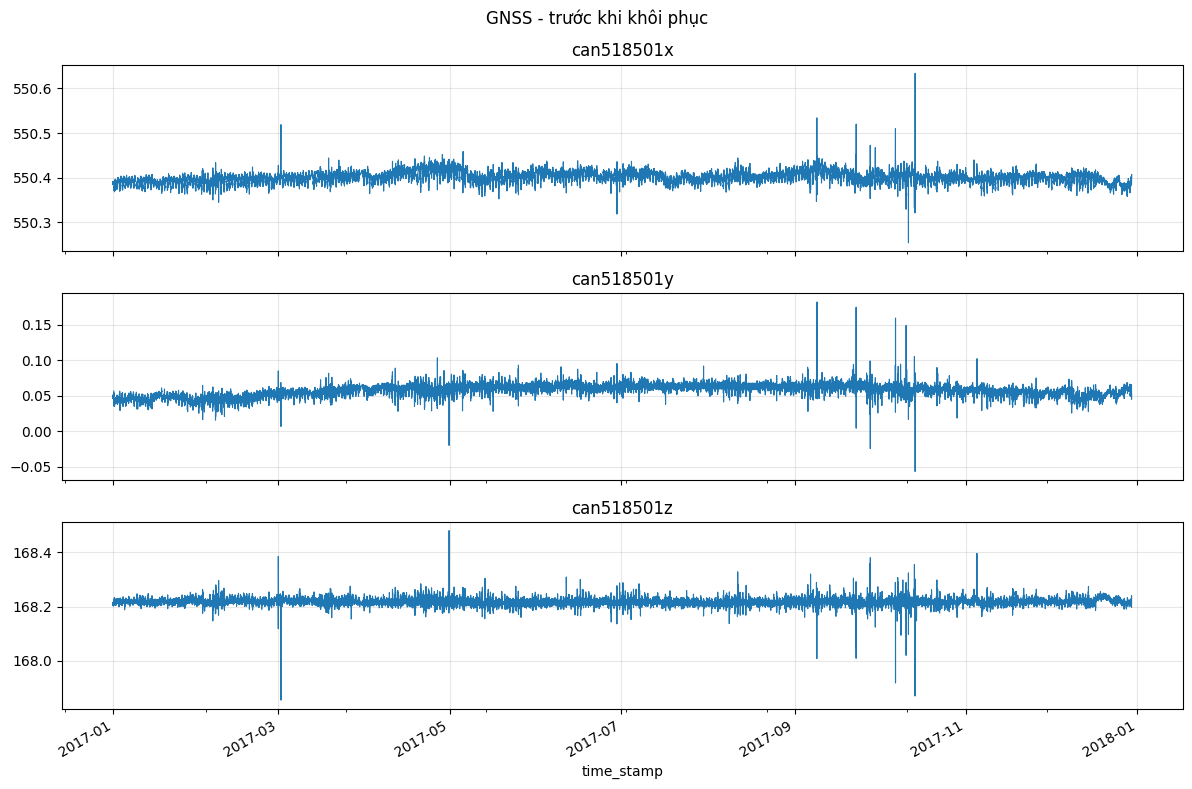

In [10]:
# Quan sát nhanh các kênh trước khi khôi phục
fig, axes = plt.subplots(len(TARGET_COLUMNS), 1, figsize=(12, 8), sharex=True)
for ax, col in zip(axes, TARGET_COLUMNS):
    target_with_gap[col].plot(ax=ax, lw=0.8)
    ax.set_title(col)
    ax.grid(True, alpha=0.3)
fig.suptitle("GNSS - trước khi khôi phục")
plt.tight_layout()


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Đường dẫn checkpoint VisionTS (cần chứa các file mae_visualize_vit_*.pth).
# Điều chỉnh lại nếu bạn lưu checkpoint ở vị trí khác.
CKPT_DIR = Path("project/benchmarks/ckpt")

visionts = VisionTS(arch="mae_base", ckpt_dir=str(CKPT_DIR), load_ckpt=True)
imputer = VisionTSMissingImputer(
visionts,
device=device,
max_context=512,
periodicity=1,
)

imputed_array = imputer.impute(
    target_with_gap.to_numpy(),
    missing_intervals,
    fp64=False,
)

imputed = pd.DataFrame(
    imputed_array,
    index=target_with_gap.index,
    columns=TARGET_COLUMNS,
)
imputed.head()


,can518501x,can518501y,can518501z
time_stamp,,,
2017-01-01 00:00:00,550.3847,0.0478,168.2111
2017-01-01 00:10:00,550.3870,0.0495,168.2121
2017-01-01 00:20:00,550.3883,0.0488,168.2071
2017-01-01 00:30:00,550.3891,0.0489,168.2071
2017-01-01 00:40:00,550.3843,0.0466,168.2061


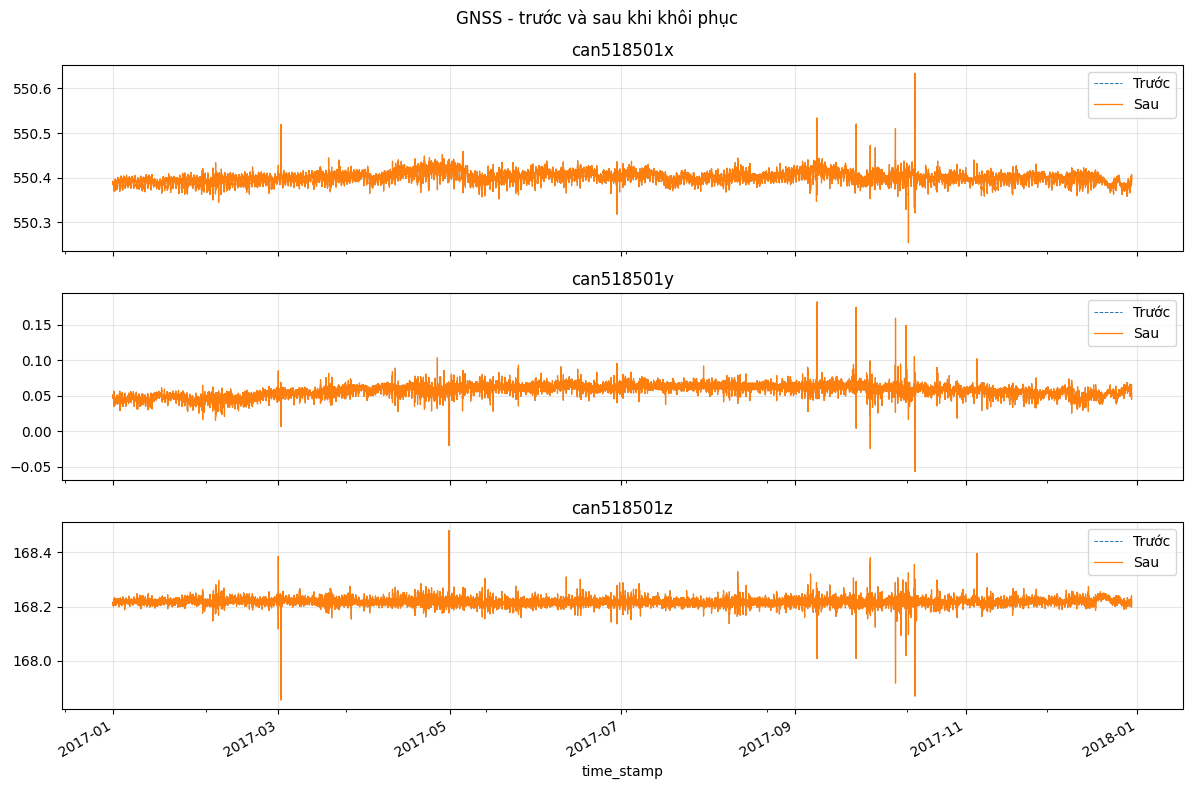

In [13]:
# So sánh sau khi khôi phục
fig, axes = plt.subplots(len(TARGET_COLUMNS), 1, figsize=(12, 8), sharex=True)
for ax, col in zip(axes, TARGET_COLUMNS):
    target_with_gap[col].plot(ax=ax, style="--", lw=0.7, label="Trước")
    imputed[col].plot(ax=ax, lw=0.9, label="Sau")
    ax.set_title(col)
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)
fig.suptitle("GNSS - trước và sau khi khôi phục")
plt.tight_layout()


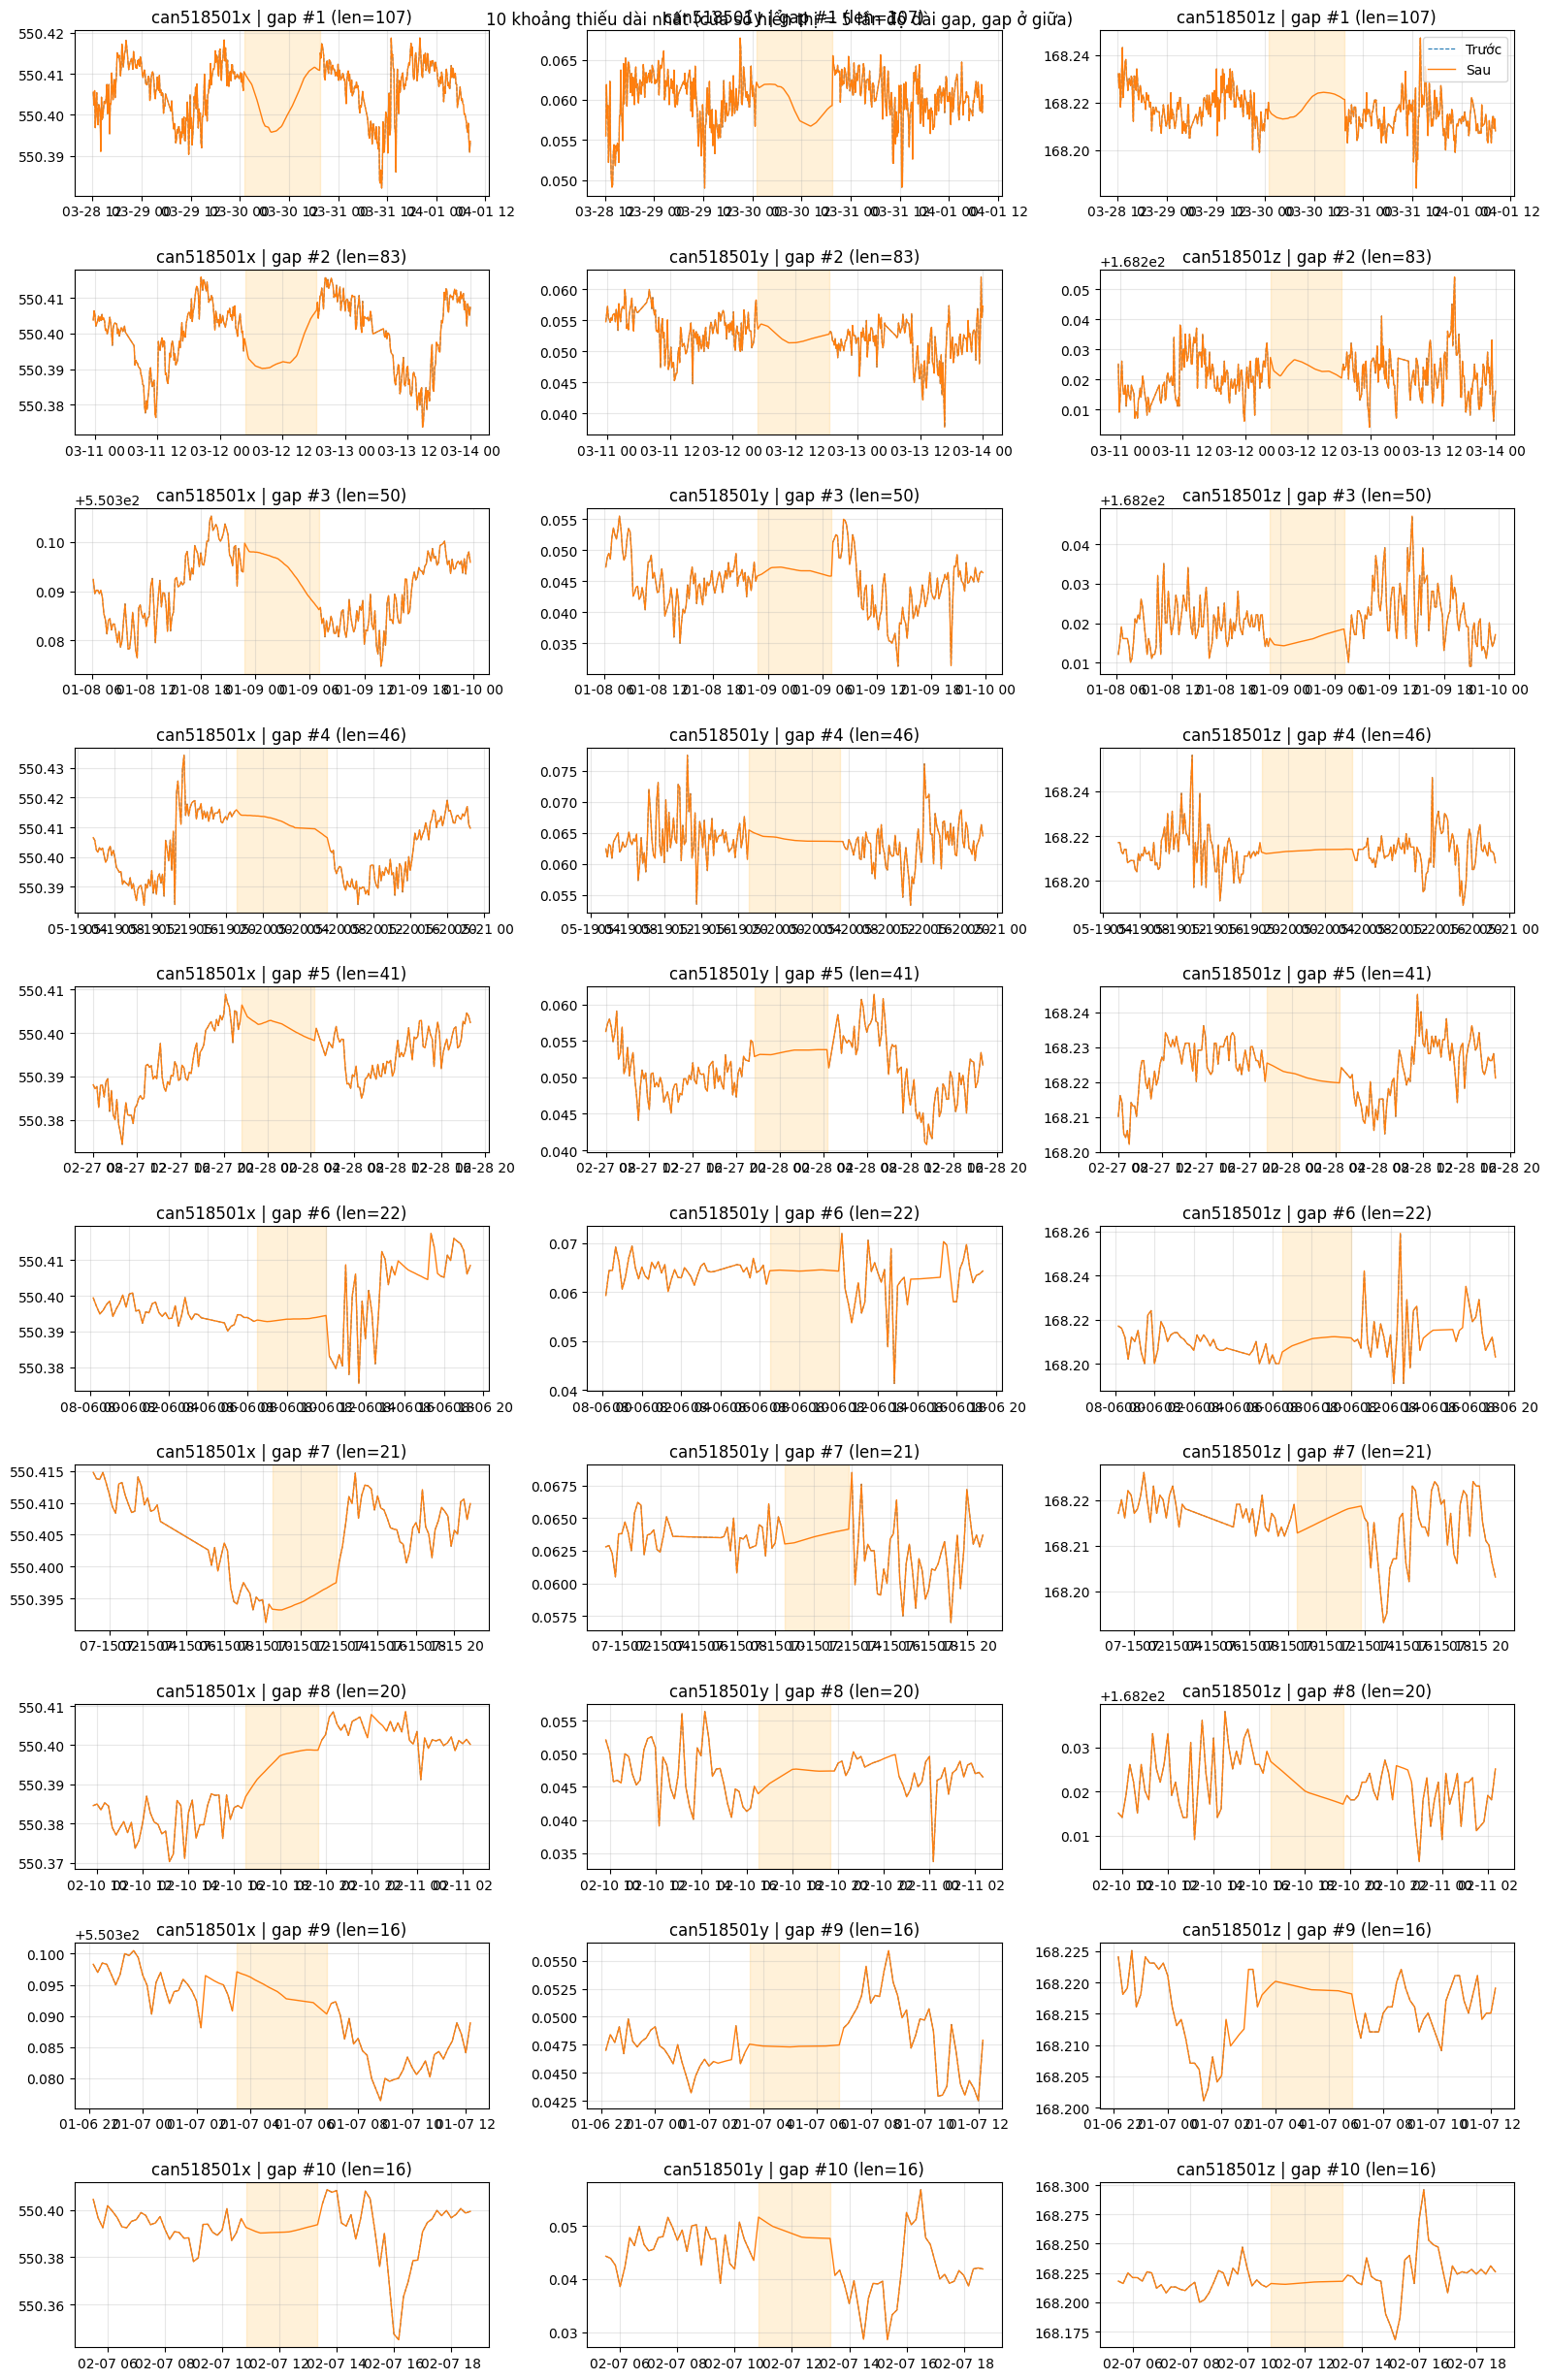

In [14]:
# So sánh chi tiết 10 khoảng thiếu dài nhất trước và sau khi khôi phục
from math import ceil

if not missing_intervals:
    print('Không có khoảng thiếu để hiển thị.')
else:
    def _to_tuple(interval):
        if isinstance(interval, MissingInterval):
            return interval.start, interval.length
        start, length = interval
        return int(start), int(length)

    sorted_intervals = sorted(
        (_to_tuple(interval) for interval in missing_intervals),
        key=lambda tpl: tpl[1],
        reverse=True,
    )[:10]

    total = len(sorted_intervals)
    fig, axes = plt.subplots(
        total,
        len(TARGET_COLUMNS),
        figsize=(16, max(3, total * 2.5)),
        sharex=False,
        sharey=False,
    )
    if total == 1:
        axes = np.array([axes])

    for row, (start, length) in enumerate(sorted_intervals):
        pre = max(1, length * 2)
        post = max(1, length * 2)
        left = max(0, start - pre)
        right = min(len(target_with_gap), start + length + post)
        idx_slice = target_with_gap.index[left:right]

        for col, column_name in enumerate(TARGET_COLUMNS):
            ax = axes[row, col]
            ax.plot(idx_slice, target_with_gap[column_name].iloc[left:right], '--', lw=0.8, label='Trước')
            ax.plot(idx_slice, imputed[column_name].iloc[left:right], lw=1.0, label='Sau')
            gap_start_ts = target_with_gap.index[start]
            gap_end_ts = target_with_gap.index[min(start + length - 1, len(target_with_gap) - 1)]
            ax.axvspan(gap_start_ts, gap_end_ts, color='orange', alpha=0.15)
            ax.set_title(f'{column_name} | gap #{row + 1} (len={length})')
            ax.grid(True, alpha=0.3)
            if row == 0 and col == len(TARGET_COLUMNS) - 1:
                ax.legend(loc='upper right')

    fig.suptitle('10 khoảng thiếu dài nhất (cửa sổ hiển thị = 5 lần độ dài gap, gap ở giữa)')
    plt.tight_layout()


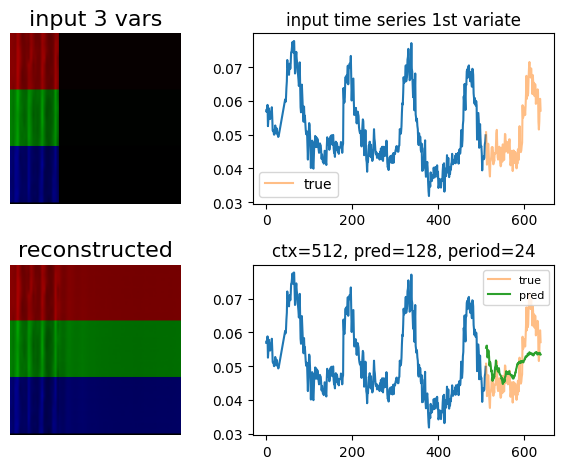

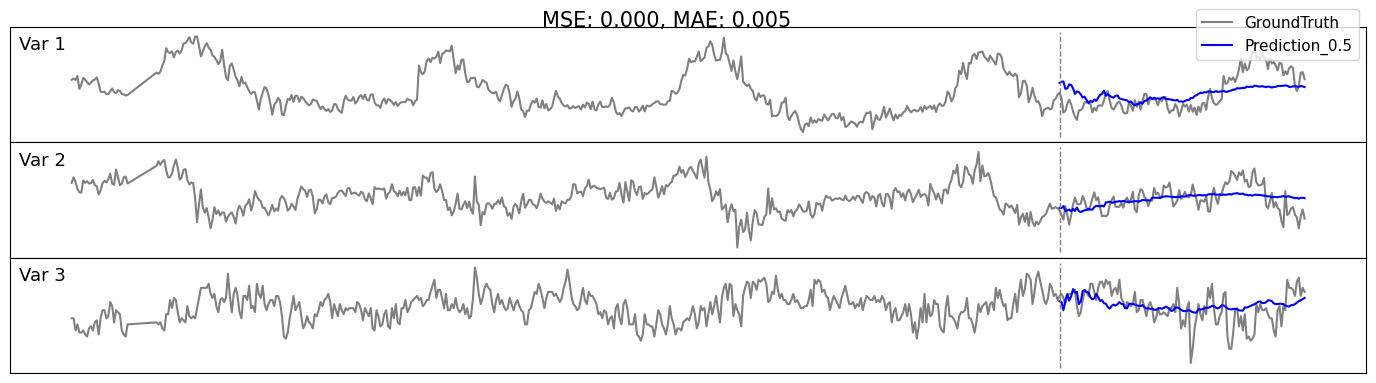

In [15]:
# ---
# Chuẩn bị môi trường & hàm tiện ích giống demo.ipynb
# ---
import sys
from pathlib import Path

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Đảm bảo import được thư viện cục bộ
PROJECT_ROOT = Path.cwd()
SRC_DIR = PROJECT_ROOT / "src"
if SRC_DIR.exists():
    sys.path.insert(0, str(SRC_DIR))
else:
    raise FileNotFoundError(f"Không tìm thấy thư mục src tại {SRC_DIR}")

from uni2ts.model.visionts import VisionTS

# Các hằng giống demo
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
FIGURES_DIR = PROJECT_ROOT / "figures_demo"
FIGURES_DIR.mkdir(exist_ok=True, parents=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CKPT_DIR = PROJECT_ROOT / "project" / "benchmarks" / "ckpt"

model = VisionTS(
    arch="mae_base",
    ckpt_dir=str(CKPT_DIR),
    load_ckpt=True,
)
model = model.to(DEVICE).eval()

def show_image(image, title="", cur_nvars=1, cur_color_list=None):
    cur_image = torch.zeros_like(image).cpu()
    height_per_var = image.shape[0] // cur_nvars
    for i in range(cur_nvars):
        channel = cur_color_list[i]
        cur_image[i * height_per_var : (i + 1) * height_per_var, :, channel] = (
            image[i * height_per_var : (i + 1) * height_per_var, :, channel].cpu()
            * imagenet_std[channel]
            + imagenet_mean[channel]
        ) * 255
    cur_image = torch.clip(cur_image, 0, 255).int()
    plt.imshow(cur_image)
    plt.title(title, fontsize=16)
    plt.axis("off")


FONT_LEGEND = 8
def run(x, y, periodicity, nvars=1, color_list=None):
    x = torch.Tensor(einops.rearrange(x, "t m -> 1 t m")).to(DEVICE)
    y = torch.Tensor(einops.rearrange(y, "t m -> 1 t m")).to(DEVICE)

    model.update_config(
        context_len=x.shape[1],
        pred_len=y.shape[1],
        periodicity=periodicity,
        norm_const=0.4,
        align_const=0.4,
        interpolation="bilinear",
    )

    with torch.no_grad():
        y_pred, input_image, reconstructed_image = model.forward(
            x, export_image=True
        )

    if isinstance(y_pred, (list, tuple)):
        y_pred_tensor, y_pred_quantile_list = y_pred
    else:
        y_pred_tensor = y_pred
        y_pred_quantile_list = None

    plt.subplot(2, 2, 1)
    show_image(input_image[0, 0], f"input {nvars} vars", nvars, color_list)

    plt.subplot(2, 2, 2)
    plt.plot(x.cpu()[0, :, 0])
    plt.plot(torch.arange(y.shape[1]) + x.shape[1], y.cpu()[0, :, 0], label="true", alpha=0.5)
    plt.title("input time series 1st variate")
    plt.legend()
    plt.tight_layout()

    plt.subplot(2, 2, 3)
    show_image(reconstructed_image[0, 0], "reconstructed", nvars, color_list)

    plt.subplot(2, 2, 4)
    plt.plot(x.cpu()[0, :, 0])
    plt.plot(torch.arange(y.shape[1]) + x.shape[1], y.cpu()[0, :, 0], label="true", alpha=0.5)
    plt.plot(torch.arange(y.shape[1]) + x.shape[1], y_pred_tensor.cpu()[0, :, 0], label="pred")

    if y_pred_quantile_list is not None:
        for j, y_pred_quantile in enumerate(y_pred_quantile_list):
            label_suffix = f"0.{j+1}" if j < len(y_pred_quantile_list) // 2 else f"0.{j+2}"
            plt.plot(
                torch.arange(y.shape[1]) + x.shape[1],
                y_pred_quantile.cpu()[0, :, 0],
                label=f"pred_{label_suffix}",
                color=f"C{j+2}",
                alpha=0.5,
            )

    plt.title(f"ctx={x.shape[1]}, pred={y.shape[1]}, period={periodicity}")
    plt.legend(fontsize=FONT_LEGEND)
    plt.tight_layout()
    plt.show()

    def visual_ts(true, preds=None, name="prediction.pdf", lookback_len_visual=300, pred_len=100):
        true = true[-lookback_len_visual - pred_len :]
        if preds is not None:
            preds = preds[-lookback_len_visual - pred_len :]
        nvars_local = true.shape[1]
        fig, axes = plt.subplots(
            nrows=nvars_local,
            ncols=1,
            figsize=(17.5, nvars_local * 1.5),
            sharex=True,
            gridspec_kw={"height_ratios": [1] * nvars_local},
        )
        plt.subplots_adjust(hspace=0)
        for i, ax in enumerate(axes if nvars_local > 1 else [axes]):
            ax.plot(true[:, i], label="GroundTruth", color="gray", linewidth=1.5)
            if preds is not None:
                ax.plot(
                    np.arange(lookback_len_visual, len(true)),
                    preds[lookback_len_visual:, i],
                    label="Prediction_0.5",
                    color="blue",
                    linewidth=1.5,
                )
            ax.vlines(
                x=lookback_len_visual,
                ymin=ax.get_ylim()[0],
                ymax=ax.get_ylim()[1],
                linewidth=1,
                linestyles="dashed",
                colors="gray",
            )
            ax.tick_params(axis="both", which="both", length=0)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.text(0.007, 0.8, f"Var {i + 1}", transform=ax.transAxes, fontsize=13)

        if preds is not None:
            handles, labels = axes[0].get_legend_handles_labels()
            fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.9, 0.935), prop={"size": 11})

            preds_calc = preds[-pred_len:]
            true_calc = true[-pred_len:]
            mse = np.mean((preds_calc - true_calc) ** 2)
            mae = np.mean(np.abs(preds_calc - true_calc))
            fig.suptitle(f"MSE: {mse:.3f}, MAE: {mae:.3f}", fontsize=15, y=0.915)

        plt.savefig(name, bbox_inches="tight", dpi=300)
        plt.show()

    cur_gt = np.concatenate([x[0].cpu().numpy(), y[0].cpu().numpy()], axis=0)
    cur_pred = np.concatenate([x[0].cpu().numpy(), y_pred_tensor[0].cpu().numpy()], axis=0)
    visual_ts(
        true=cur_gt,
        preds=cur_pred,
        name=str(FIGURES_DIR / "prediction.pdf"),
        lookback_len_visual=x.shape[1],
        pred_len=y.shape[1],
    )

    def save_image(image, title="", cur_nvars=1, cur_color_list=None, save_path="image.pdf"):
        cur_image = torch.zeros_like(image).cpu()
        height_per_var = image.shape[0] // cur_nvars
        for i in range(cur_nvars):
            channel = cur_color_list[i]
            cur_image[i * height_per_var : (i + 1) * height_per_var, :, channel] = (
                image[i * height_per_var : (i + 1) * height_per_var, :, channel].cpu()
                * imagenet_std[channel]
                + imagenet_mean[channel]
            ) * 255
        cur_image = torch.clip(cur_image, 0, 255).int()
        plt.figure(figsize=(10, 10))
        plt.imshow(cur_image)
        plt.title(title, fontsize=16)
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()

    save_image(input_image[0, 0], "input", nvars, color_list, FIGURES_DIR / "input.pdf")
    save_image(reconstructed_image[0, 0], "reconstructed", nvars, color_list, FIGURES_DIR / "reconstructed.pdf")


# ---
# 1. Đọc và chuẩn hóa GNSS
# ---
df = pd.read_csv("datasets/GNSS.csv")
df["time_stamp"] = pd.to_datetime(df["time_stamp"], format="%Y%m%d%H%M%S")
df = df.sort_values("time_stamp")
target_cols = ["can517501x", "can517501y", "can517501z"]
sentinel = -9999.0
values = (
    df[target_cols]
    .apply(pd.to_numeric, errors="coerce")
    .replace(sentinel, np.nan)
    .interpolate(limit_direction="both")
    .to_numpy()
)

# 2. Tạo cặp (x, y)
context_len = 512
pred_len = 128
series = values[: context_len + pred_len]
x = series[:context_len]
y = series[context_len:]

# 3. Periodicity & màu
periodicity = 24
nvars = x.shape[1]
color_list = [i % 3 for i in range(nvars)]

# 4. Gọi run để hiển thị
run(x, y, periodicity=periodicity, nvars=nvars, color_list=color_list)


In [22]:
# Huấn luyện nhanh VisionTS trên dữ liệu GNSS (fine-tune)
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.auto import tqdm

class GNSSWindowDataset(Dataset):
    def __init__(self, array: np.ndarray, context: int, pred: int, stride: int | None = None):
        self.context = context
        self.pred = pred
        self.stride = stride or max(1, pred // 2)
        self.samples: list[tuple[np.ndarray, np.ndarray]] = []
        total = array.shape[0]
        for start in range(0, total - context - pred + 1, self.stride):
            ctx = array[start : start + context]
            fut = array[start + context : start + context + pred]
            if np.isnan(ctx).any() or np.isnan(fut).any():
                continue
            self.samples.append((ctx.astype(np.float32), fut.astype(np.float32)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ctx, fut = self.samples[idx]
        return torch.from_numpy(ctx), torch.from_numpy(fut)

context_len_train = context_len
pred_len_train = pred_len
gnss_dataset = GNSSWindowDataset(values, context_len_train, pred_len_train, stride=pred_len_train // 2)
if len(gnss_dataset) == 0:
    raise ValueError('Không tạo được mẫu huấn luyện nào từ dữ liệu GNSS (còn NaN hoặc chuỗi quá ngắn).')

batch_size = 8
dataloader = DataLoader(gnss_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

model.update_config(
    context_len=context_len_train,
    pred_len=pred_len_train,
    periodicity=periodicity,
    norm_const=0.4,
    align_const=0.4,
    interpolation='bilinear',
)

model.train()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
num_epochs = 100
loss_history = []
best_loss = float("inf")
best_state = None
for epoch in range(num_epochs):
    running_loss = 0.0
    for ctx_batch, tgt_batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        ctx_batch = ctx_batch.to(DEVICE)
        tgt_batch = tgt_batch.to(DEVICE)

        optimizer.zero_grad()
        preds = model(ctx_batch)
        loss = F.mse_loss(preds, tgt_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * ctx_batch.size(0)

    epoch_loss = running_loss / (len(dataloader) * batch_size)
    loss_history.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.6f}')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        torch.save(best_state, "best.pth")          # lưu checkpoint tốt nhất

model.eval()
print('Fine-tune hoàn tất. Có thể chạy lại run() để quan sát kết quả.')

Epoch 1/100:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 1/100 - Loss: 0.000027


Epoch 2/100:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2/100 - Loss: 0.000027


Epoch 3/100:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 3/100 - Loss: 0.000027


Epoch 4/100:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 4/100 - Loss: 0.000027


Epoch 5/100:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 5/100 - Loss: 0.000027


Epoch 6/100:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 6/100 - Loss: 0.000027


Epoch 7/100:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 7/100 - Loss: 0.000027


Epoch 8/100:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 8/100 - Loss: 0.000027


Epoch 9/100:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 9/100 - Loss: 0.000027


Epoch 10/100:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 10/100 - Loss: 0.000027


Epoch 11/100:   0%|          | 0/97 [00:00<?, ?it/s]

KeyboardInterrupt: 

Đã load mô hình tốt nhất từ best.pth
Dataset có 779 mẫu, chạy 3 trường hợp đầu:

--- Mẫu 1 ---


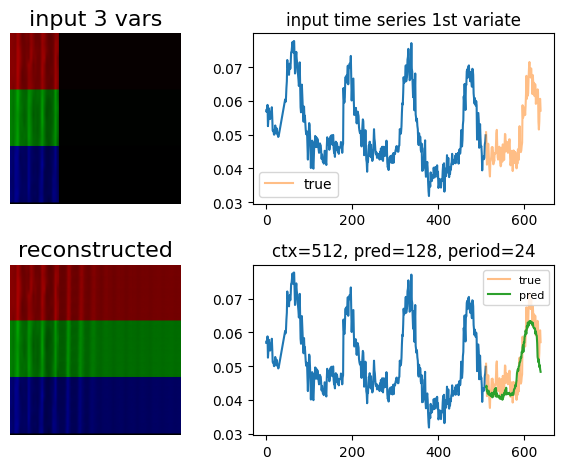

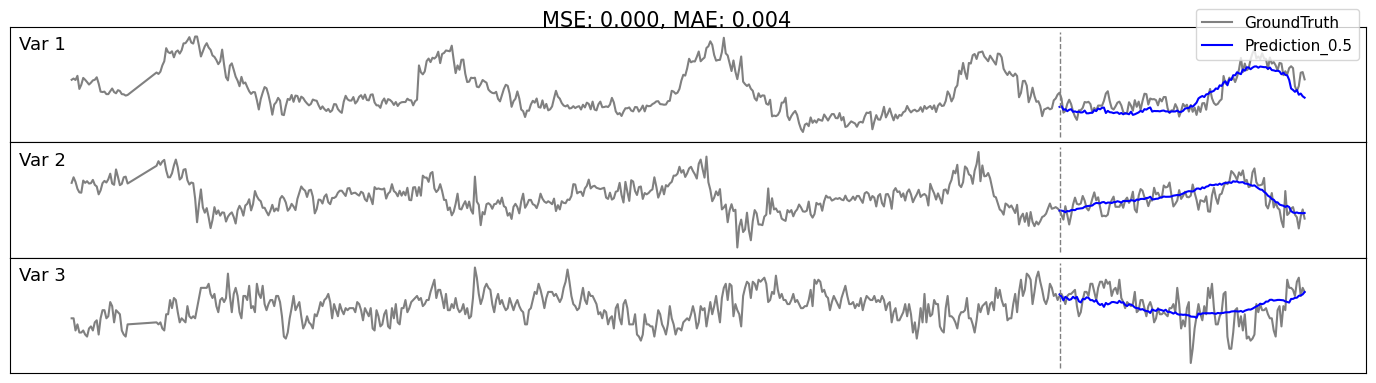


--- Mẫu 2 ---


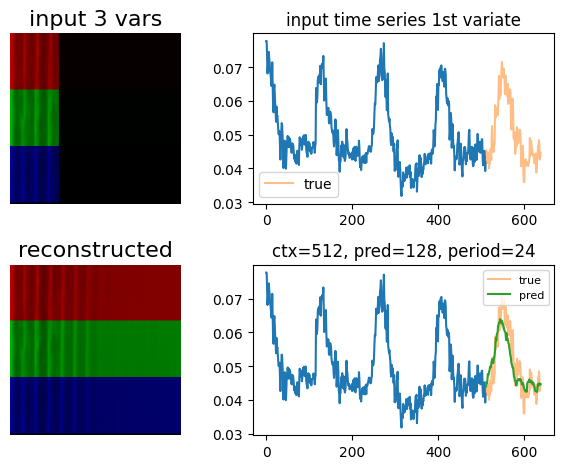

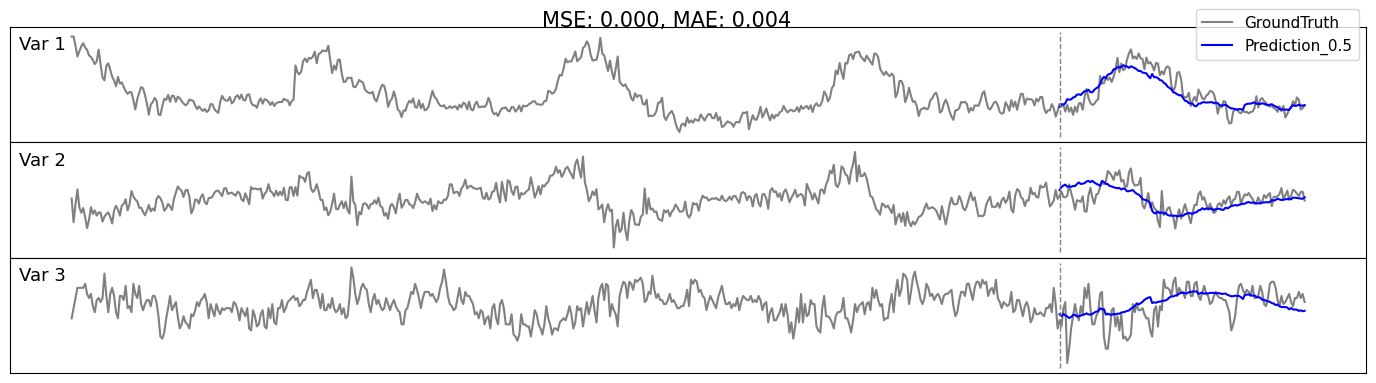


--- Mẫu 3 ---


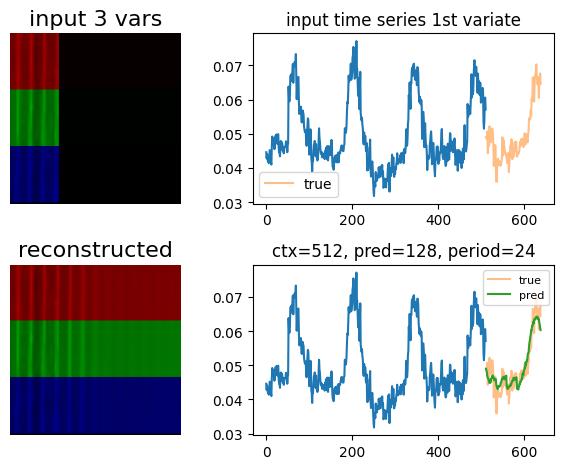

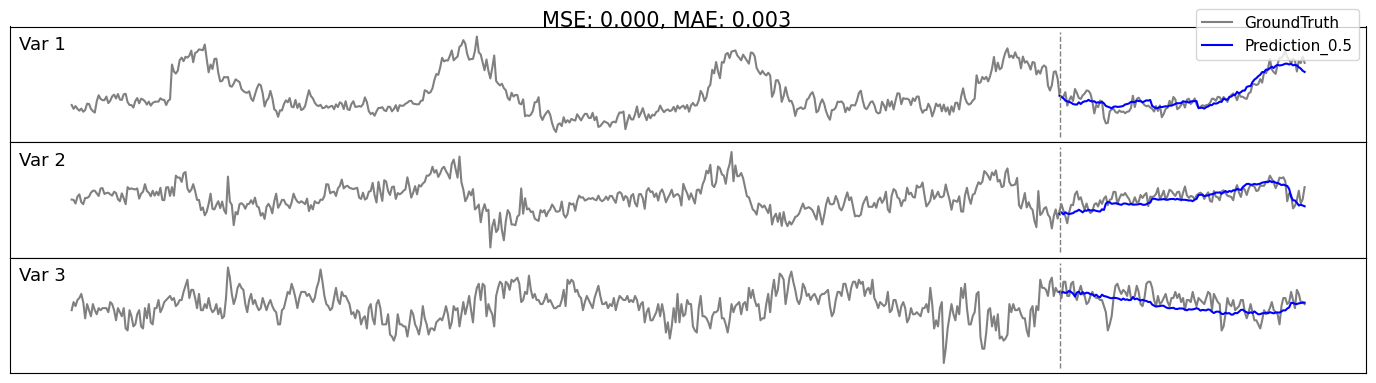


Đã hoàn thành imputation với mô hình fine-tuned


In [29]:
# Tải checkpoint tốt nhất
best_path = PROJECT_ROOT / "best.pth"
if best_path.exists():
    ckpt = torch.load(best_path, map_location=DEVICE)
    model.load_state_dict(ckpt)
    model.eval()
    print("Đã load mô hình tốt nhất từ best.pth")

    # Chạy cho vài trường hợp từ gnss_dataset
    print(f"Dataset có {len(gnss_dataset)} mẫu, chạy 3 trường hợp đầu:")
    for i in range(min(3, len(gnss_dataset))):
        print(f"\n--- Mẫu {i+1} ---")
        sample_ctx, sample_tgt = gnss_dataset[i]
        run(
            sample_ctx.numpy(),
            sample_tgt.numpy(),
            periodicity=periodicity,
            nvars=sample_ctx.shape[1],
            color_list=[i % 3 for i in range(sample_ctx.shape[1])],
        )

    # Hoặc dùng imputer để khôi phục toàn bộ chuỗi với mô hình tốt nhất
    imputer = VisionTSMissingImputer(
        model,
        device=DEVICE,
        max_context=context_len,
        max_horizon=pred_len,
        periodicity=periodicity,
        norm_const=0.4,
    )
    imputed_best = imputer.impute(
        target_with_gap.to_numpy(),
        missing_intervals,
        fp64=False,
    )
    print("\nĐã hoàn thành imputation với mô hình fine-tuned")
else:
    print("Chưa tìm thấy best.pth – hãy chắc chắn cell huấn luyện đã chạy và lưu checkpoint trước.")


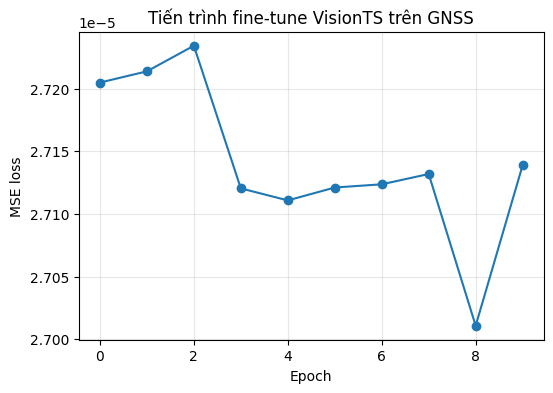

In [25]:
plt.figure(figsize=(6, 4))
plt.plot(loss_history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Tiến trình fine-tune VisionTS trên GNSS")
plt.grid(True, alpha=0.3)
plt.show()

In [26]:
# --- Khôi phục bằng VisionTS (dùng mô hình đã fine-tune) ---

device = DEVICE
model.eval()

imputer = VisionTSMissingImputer(
    model,
    device=device,
    max_context=context_len,
    max_horizon=pred_len,
    periodicity=periodicity,
    norm_const=0.4,
)

imputed_array = imputer.impute(
    target_with_gap.to_numpy(),
    missing_intervals,
    fp64=False,
)

imputed = pd.DataFrame(
    imputed_array,
    index=target_with_gap.index,
    columns=TARGET_COLUMNS,
)
imputed.head()


,can518501x,can518501y,can518501z
time_stamp,,,
2017-01-01 00:00:00,550.3847,0.0478,168.2111
2017-01-01 00:10:00,550.3870,0.0495,168.2121
2017-01-01 00:20:00,550.3883,0.0488,168.2071
2017-01-01 00:30:00,550.3891,0.0489,168.2071
2017-01-01 00:40:00,550.3843,0.0466,168.2061


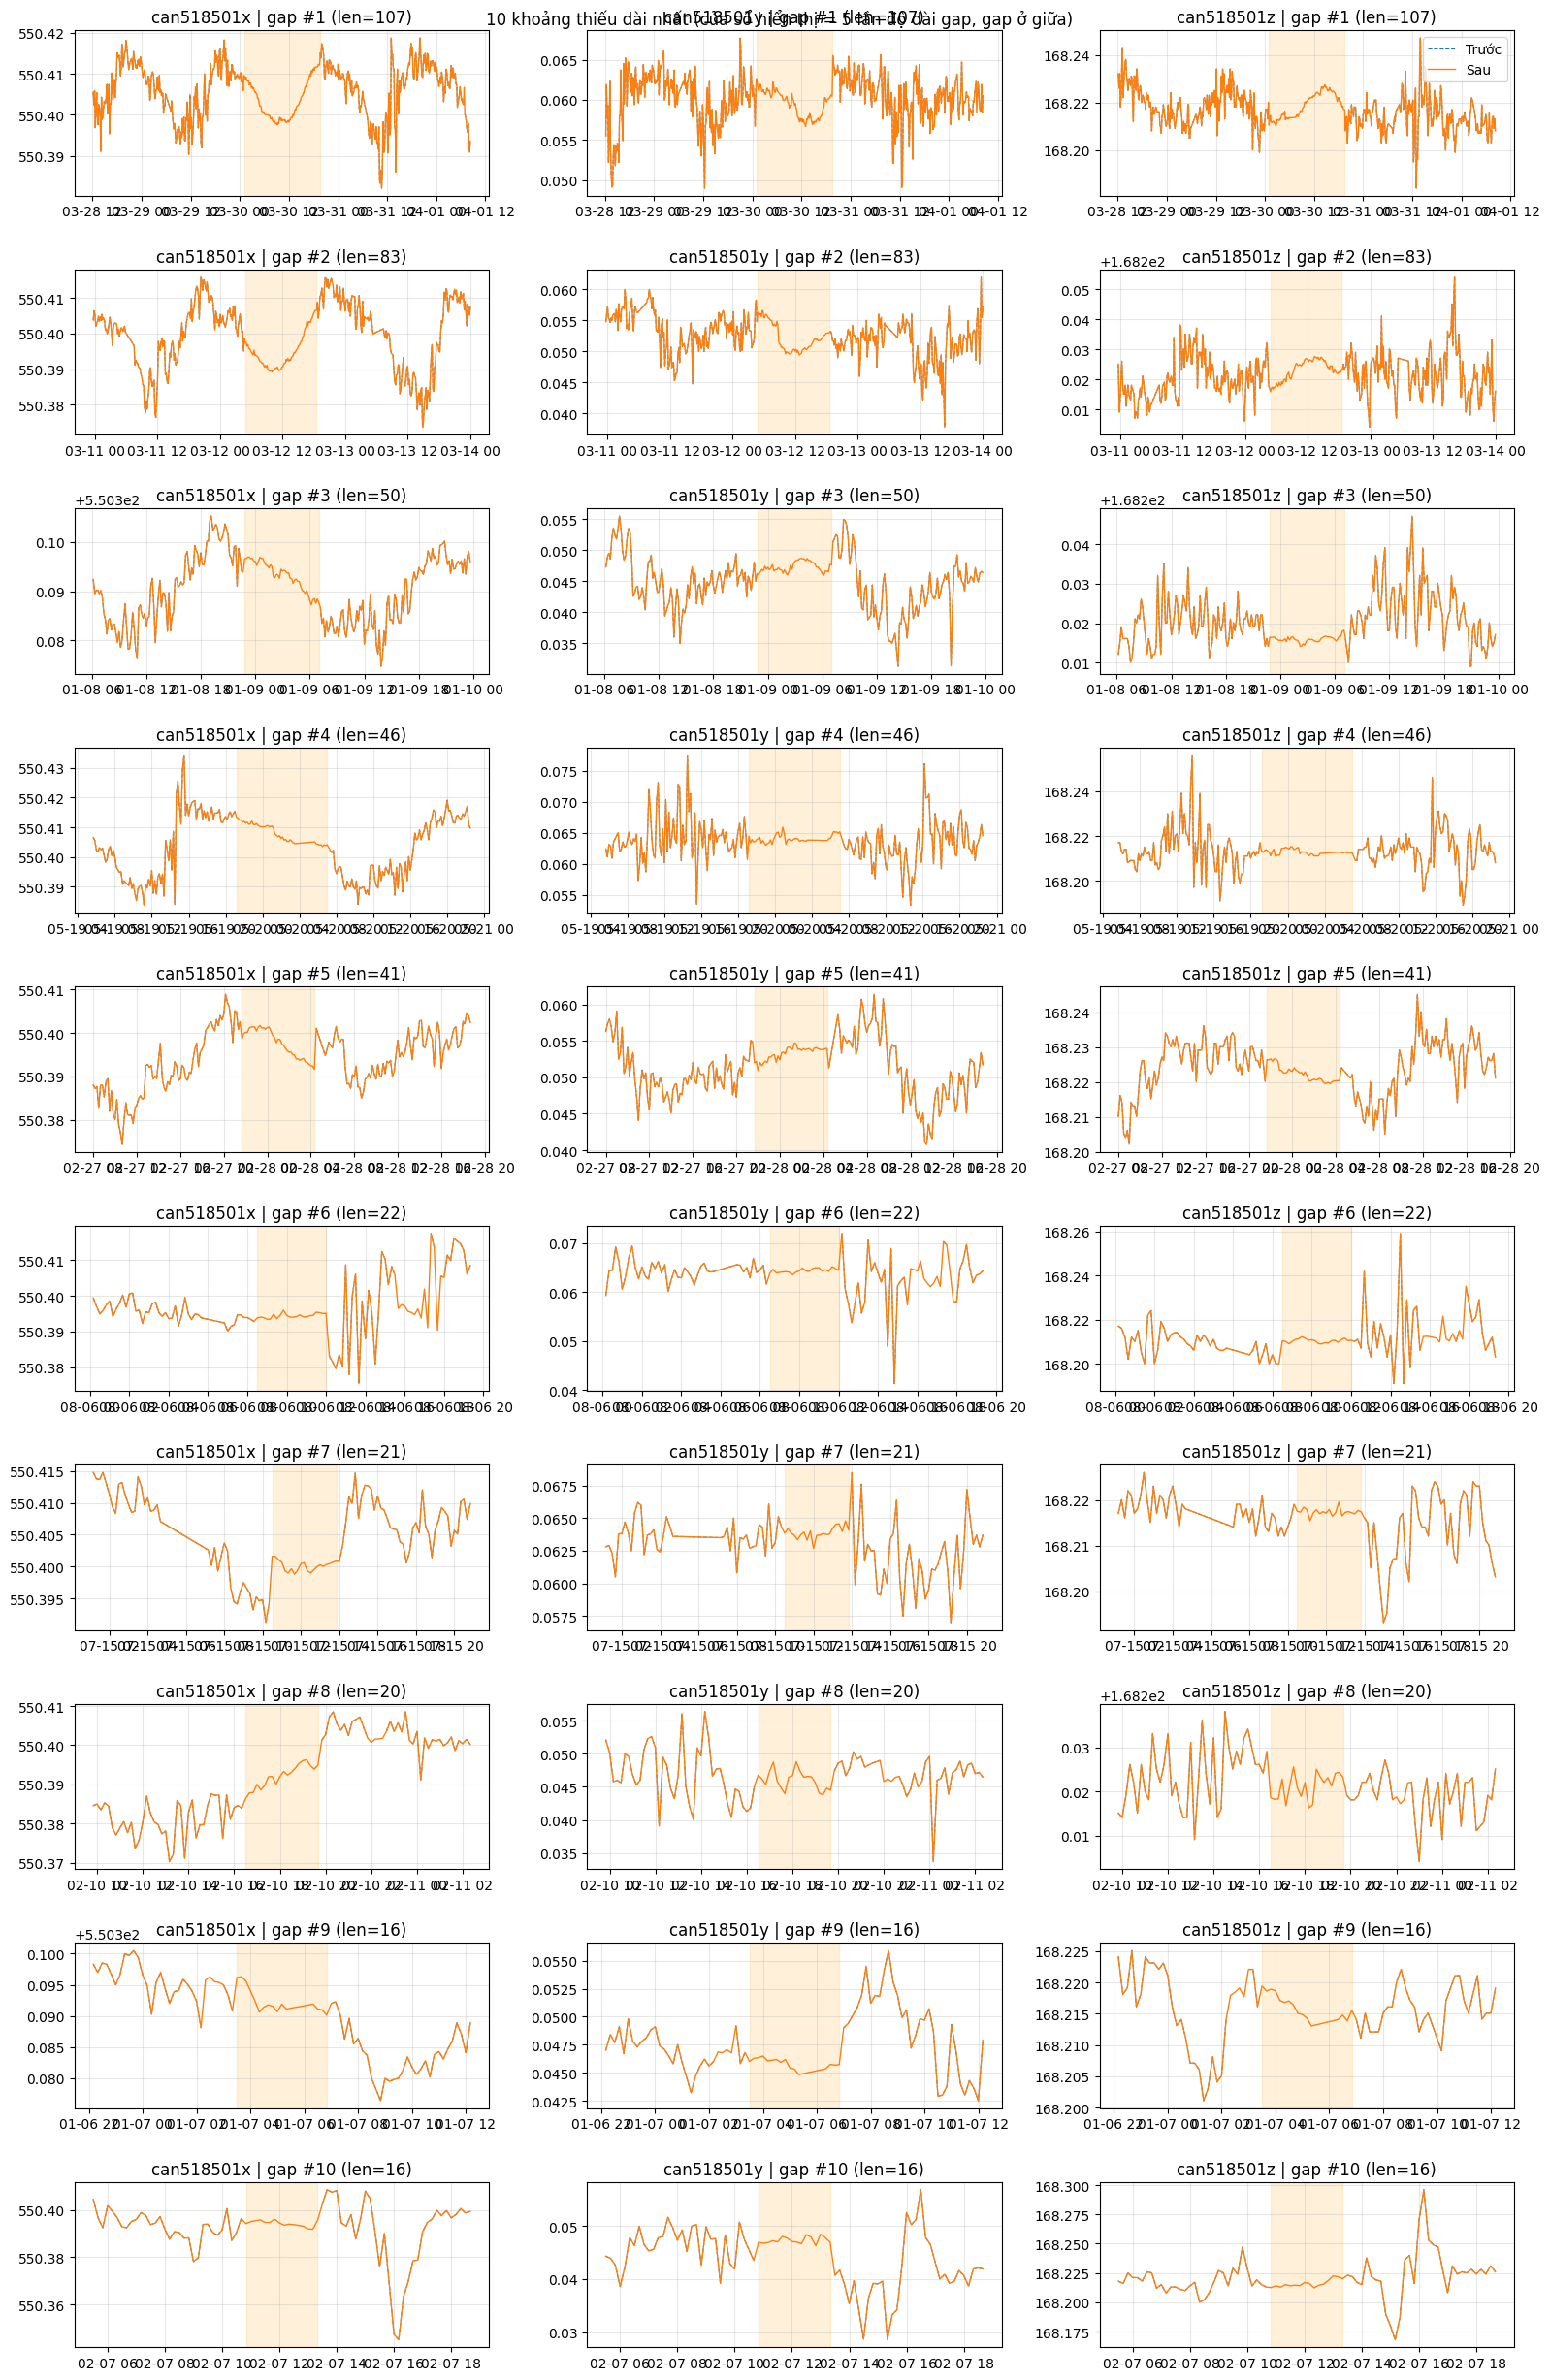

In [27]:
# So sánh chi tiết 10 khoảng thiếu dài nhất trước và sau khi khôi phục
from math import ceil

if not missing_intervals:
    print('Không có khoảng thiếu để hiển thị.')
else:
    def _to_tuple(interval):
        if isinstance(interval, MissingInterval):
            return interval.start, interval.length
        start, length = interval
        return int(start), int(length)

    sorted_intervals = sorted(
        (_to_tuple(interval) for interval in missing_intervals),
        key=lambda tpl: tpl[1],
        reverse=True,
    )[:10]

    total = len(sorted_intervals)
    fig, axes = plt.subplots(
        total,
        len(TARGET_COLUMNS),
        figsize=(16, max(3, total * 2.5)),
        sharex=False,
        sharey=False,
    )
    if total == 1:
        axes = np.array([axes])

    for row, (start, length) in enumerate(sorted_intervals):
        pre = max(1, length * 2)
        post = max(1, length * 2)
        left = max(0, start - pre)
        right = min(len(target_with_gap), start + length + post)
        idx_slice = target_with_gap.index[left:right]

        for col, column_name in enumerate(TARGET_COLUMNS):
            ax = axes[row, col]
            ax.plot(idx_slice, target_with_gap[column_name].iloc[left:right], '--', lw=0.8, label='Trước')
            ax.plot(idx_slice, imputed[column_name].iloc[left:right], lw=1.0, label='Sau')
            gap_start_ts = target_with_gap.index[start]
            gap_end_ts = target_with_gap.index[min(start + length - 1, len(target_with_gap) - 1)]
            ax.axvspan(gap_start_ts, gap_end_ts, color='orange', alpha=0.15)
            ax.set_title(f'{column_name} | gap #{row + 1} (len={length})')
            ax.grid(True, alpha=0.3)
            if row == 0 and col == len(TARGET_COLUMNS) - 1:
                ax.legend(loc='upper right')

    fig.suptitle('10 khoảng thiếu dài nhất (cửa sổ hiển thị = 5 lần độ dài gap, gap ở giữa)')
    plt.tight_layout()


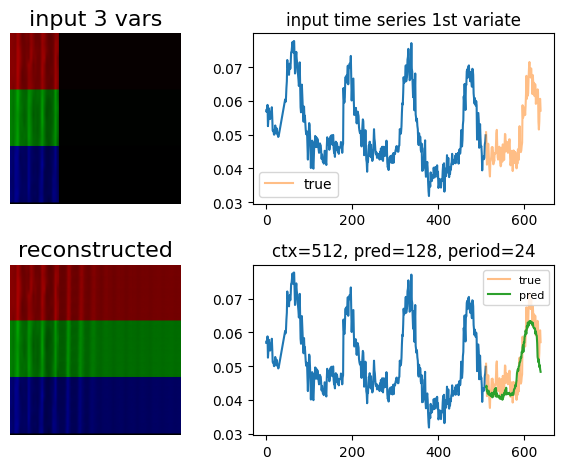

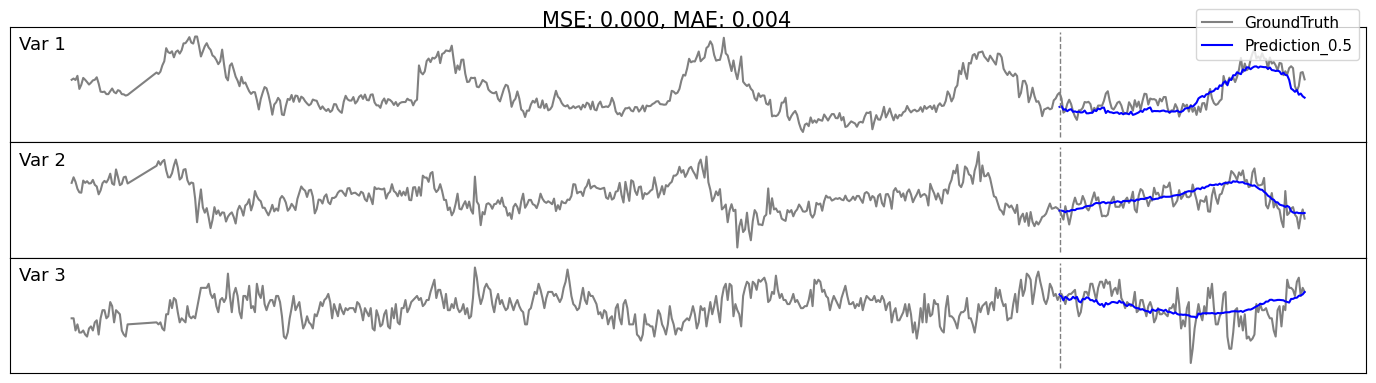

In [28]:
run(x, y, periodicity=periodicity, nvars=nvars, color_list=color_list)